In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

In [17]:
from typing import Dict, Tuple
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from surprise import SVD, Dataset, Reader
from matplotlib_venn import venn2
%matplotlib inline 
sns.set(style="ticks")

In [3]:
data=pd.read_csv('ITService.csv', sep=",")

In [4]:
#размер датасета
data.shape

(51, 7)

In [45]:
data.head()

,id,ServiceName,ServiceDescription,ServicePrice,ServiceType,Time,Guarantee
0,1,Рекомендации по работе на компьютере,Рекомендации по безопасной работе в сети Интернет,"2,000.00",Рекомендации,3,0
1,2,Рекомендации по работе на смартфоне,Рекомендации по безопасной работе в сети Интернет,"2,000.00",Рекомендации,3,0
2,3,Рекомендации по работе на планшете,Рекомендации по безопасной работе в сети Интернет,"2,000.00",Рекомендации,3,0
3,4,Рекомендации по созданию и хранению безопасных...,Подбор рекомендаций с учётом ситуации,"2,000.00",Рекомендации,3,0
4,5,Рекомендации по обновлению железа,Подбор рекомендаций с учётом ситуации,"2,000.00",Рекомендации,3,0


In [46]:
# Основные статистические характеристки набора данных
data.describe()

,id,Time,Guarantee
count,51.000000,51.000000,51.000000
mean,26.000000,19.529412,78.235294
std,14.866069,19.639097,65.198340
min,1.000000,3.000000,0.000000
25%,13.500000,7.000000,30.000000
50%,26.000000,14.000000,60.000000
75%,38.500000,21.000000,150.000000
max,51.000000,60.000000,180.000000


<AxesSubplot:xlabel='ServiceType', ylabel='count'>

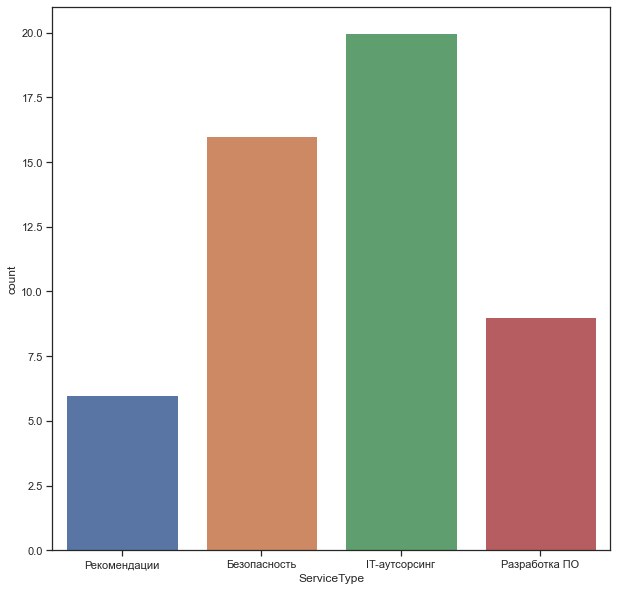

In [48]:
plt.figure(figsize=(10,10))
sns.countplot(x="ServiceType", data=data)

<StemContainer object of 3 artists>

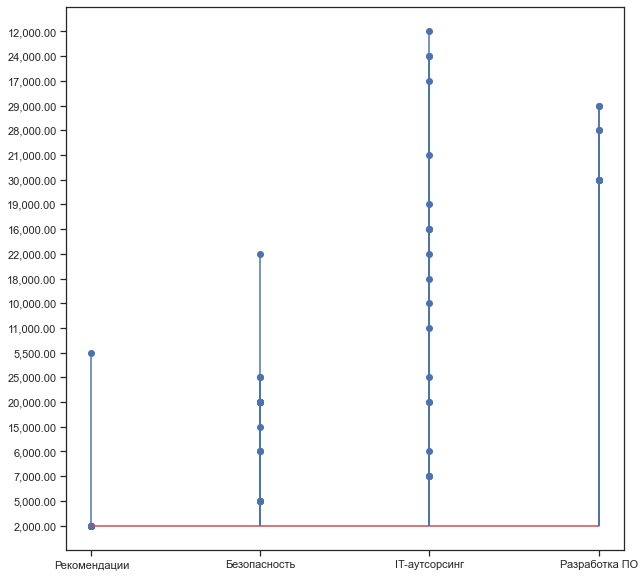

In [49]:
plt.figure(figsize=(10,10))
plt.stem(data['ServiceType'], data['ServicePrice'])

<AxesSubplot:xlabel='ServiceType', ylabel='Time'>

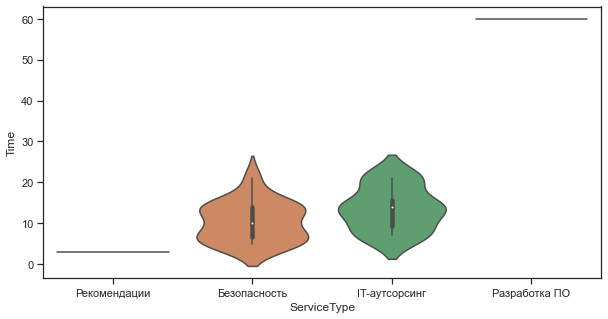

In [52]:
plt.figure(figsize=(10,5))
x=data['ServiceType']

y=data['Time']

sns.violinplot(x, y)

In [7]:
# Колонки с пропусками
data.isnull().sum()

id                    0
ServiceName           0
ServiceDescription    0
ServicePrice          0
ServiceType           0
Time                  0
Guarantee             0
dtype: int64

In [8]:
data.dtypes

id                     int64
ServiceName           object
ServiceDescription    object
ServicePrice          object
ServiceType           object
Time                   int64
Guarantee              int64
dtype: object

In [10]:
ServiceName= data['ServiceName'].values
ServiceName[0:5]

array(['Рекомендации по работе на компьютере',
       'Рекомендации по работе на смартфоне',
       'Рекомендации по работе на планшете',
       'Рекомендации по созданию и хранению безопасных паролей',
       'Рекомендации по обновлению железа'], dtype=object)

In [12]:
ServicePrice= data['ServicePrice'].values
ServicePrice[0:5]

array(['2,000.00', '2,000.00', '2,000.00', '2,000.00', '2,000.00'],
      dtype=object)

In [13]:
ServiceType= data['ServiceType'].values
ServiceType[0:5]

array(['Рекомендации', 'Рекомендации', 'Рекомендации', 'Рекомендации',
       'Рекомендации'], dtype=object)

In [14]:
ServiceDescription= data['ServiceDescription'].values
ServiceDescription[0:5]

array(['Рекомендации по безопасной работе в сети Интернет',
       'Рекомендации по безопасной работе в сети Интернет',
       'Рекомендации по безопасной работе в сети Интернет',
       'Подбор рекомендаций с учётом ситуации',
       'Подбор рекомендаций с учётом ситуации'], dtype=object)

In [15]:
Time= data['Time'].values
Time[0:5]

array([3, 3, 3, 3, 3], dtype=int64)

In [16]:
Guarantee= data['Guarantee'].values
Guarantee[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [18]:
%%time
tfidfv = TfidfVectorizer()
matrix = tfidfv.fit_transform(ServiceName)
matrix

Wall time: 8.27 ms


<51x140 sparse matrix of type '<class 'numpy.float64'>'
	with 230 stored elements in Compressed Sparse Row format>

In [53]:
class SimpleKNNRecommender:
    
    def __init__(self, X_matrix, X_ServiceType, X_ServiceName, X_ServicePrice, X_Time, X_Guarantee):
        """
        Входные параметры:
        X_matrix - обучающая выборка (матрица объект-признак)
        """
        #Сохраняем параметры в переменных объекта
        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'ServiceType': pd.Series(X_ServiceType, dtype='str'),
            'ServiceName': pd.Series(X_ServiceName, dtype='str'),
            'ServicePrice': pd.Series(X_ServicePrice, dtype='str'),
            'Time': pd.Series(X_Time, dtype='int64'),
            'Guarantee': pd.Series(X_Guarantee, dtype='int64'),
            'dist': pd.Series([], dtype='float')})
            
            
    def recommend_for_single_object(self, K: int, \
                X_matrix_object, cos_flag = True, manh_flag = False):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        cos_flag - флаг вычисления косинусного расстояния
        manh_flag - флаг вычисления манхэттэнского расстояния
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 1000000
        # Вычисляем косинусную близость
        if cos_flag:
            dist = cosine_similarity(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=False)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] < scale]
        
        else:
            if manh_flag:
                dist = manhattan_distances(self._X_matrix, X_matrix_object)
            else:
                dist = euclidean_distances(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=True)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] > 0.0]            
        
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res

In [54]:
ServiceName[5]

'Диагностика на наличие угроз и вредоносных программ'

In [55]:
mc_matrix = matrix[5]
mc_matrix

<1x140 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [56]:
skr1 = SimpleKNNRecommender(matrix, ServiceType, ServiceName, ServicePrice, Time, Guarantee)

In [57]:
rec1 = skr1.recommend_for_single_object(5, mc_matrix)
rec1

,ServiceType,ServiceName,ServicePrice,Time,Guarantee,dist
8,Безопасность,Диагностика носителей информации,"5,000.00",5,30,187121.557424
6,Безопасность,Диагностика драйверов устройств,"5,000.00",5,30,176100.595031
12,Безопасность,Удаление угроз и восстановление работоспособно...,"6,000.00",7,30,158978.576400
11,Безопасность,Удаление угроз и восстановление работоспособно...,"6,000.00",7,30,158978.576400
7,Безопасность,Диагностика параметров безопасности ПК,"5,000.00",5,30,153687.581216


In [58]:
# При поиске с помощью Евклидова расстояния 
rec2 = skr1.recommend_for_single_object(5, mc_matrix, cos_flag = False)
rec2

,ServiceType,ServiceName,ServicePrice,Time,Guarantee,dist
8,Безопасность,Диагностика носителей информации,"5,000.00",5,30,1.275052e+06
6,Безопасность,Диагностика драйверов устройств,"5,000.00",5,30,1.283666e+06
12,Безопасность,Удаление угроз и восстановление работоспособно...,"6,000.00",7,30,1.296936e+06
11,Безопасность,Удаление угроз и восстановление работоспособно...,"6,000.00",7,30,1.296936e+06
7,Безопасность,Диагностика параметров безопасности ПК,"5,000.00",5,30,1.301009e+06


In [59]:
# Манхэттэнское расстояние
rec3 = skr1.recommend_for_single_object(5, mc_matrix, 
                                        cos_flag = False, manh_flag = True)
rec3

,ServiceType,ServiceName,ServicePrice,Time,Guarantee,dist
6,Безопасность,Диагностика драйверов устройств,"5,000.00",5,30,3.410604e+06
8,Безопасность,Диагностика носителей информации,"5,000.00",5,30,3.411415e+06
7,Безопасность,Диагностика параметров безопасности ПК,"5,000.00",5,30,3.679674e+06
26,IT-аутсорсинг,ИТ-аудит,"25,000.00",21,90,3.818181e+06
49,IT-аутсорсинг,Обслуживание оргтехники,"24,000.00",21,120,3.823334e+06
